In [1]:
from __future__ import print_function, division
from builtins import range, input
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU

/home/vijay/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

In [3]:
# config
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 256
LATENT_DIM_DECODER = 256 # idea: make it different to ensure things all fit together properly!
NUM_SAMPLES = 10000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [4]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

In [5]:
t = 0
for line in open('DATASET/spa-eng/spa.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 10000


In [6]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [7]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 2368 unique input tokens.


In [8]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

In [9]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [10]:
# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 6302 unique output tokens.


In [11]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

In [12]:
# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

In [13]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape:", encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_data[0]:", decoder_inputs[0])
print("decoder_data.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_data.shape: (10000, 5)
encoder_data[0]: [ 0  0  0  0 14]
decoder_data[0]: [   2 1481    0    0    0    0    0    0    0]
decoder_data.shape: (10000, 9)


In [14]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('DATASET/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


In [15]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [16]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

In [17]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

In [18]:
# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [21]:
##### build the model #####

# Set up the encoder - simple!
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True,
  # dropout=0.5 # dropout not available on gpu
))
encoder_outputs = encoder(x)


# Set up the decoder - not so simple
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [22]:
######### Attention #########
# Attention layers need to be global because
# they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]

In [23]:
def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)
  st_1 = attn_repeat_layer(st_1)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
  x = attn_concat_layer([h, st_1])

  # Neural net first layer
  x = attn_dense1(x)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context = attn_dot([alphas, h])

  return context

In [24]:
# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [25]:
# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

In [26]:
# collect outputs in a list at first
outputs = []
for t in range(max_len_target): # Ty times
  # get the context using attention
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)
  
  # combine 
  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)

In [27]:
def stack_and_transpose(x):
  # x is a list of length T, each element is a batch_size x output_vocab_size tensor
  x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
  return x

In [28]:
# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

In [29]:
# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)

In [30]:
# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# train the model
z = np.zeros((NUM_SAMPLES, LATENT_DIM_DECODER)) # initial [s, c]
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 66s 8ms/step - loss: 2.7366 - acc: 0.6326 - val_loss: 2.6753 - val_acc: 0.6492
Epoch 2/100
8000/8000 [==============================] - 33s 4ms/step - loss: 2.0574 - acc: 0.7109 - val_loss: 2.4330 - val_acc: 0.6731
Epoch 3/100
8000/8000 [==============================] - 32s 4ms/step - loss: 1.8343 - acc: 0.7316 - val_loss: 2.2753 - val_acc: 0.6892
Epoch 4/100
8000/8000 [==============================] - 33s 4ms/step - loss: 1.6687 - acc: 0.7509 - val_loss: 2.1584 - val_acc: 0.7052
Epoch 5/100
8000/8000 [==============================] - 32s 4ms/step - loss: 1.5337 - acc: 0.7660 - val_loss: 2.0700 - val_acc: 0.7147
Epoch 6/100
8000/8000 [==============================] - 33s 4ms/step - loss: 1.4231 - acc: 0.7790 - val_loss: 2.0247 - val_acc: 0.7221
Epoch 7/100
8000/8000 [==============================] - 33s 4ms/step - loss: 1.3252 - acc: 0.7917 - val_loss: 1.9786 - val_acc: 0.7292


8000/8000 [==============================] - 33s 4ms/step - loss: 0.3052 - acc: 0.9432 - val_loss: 2.2506 - val_acc: 0.7241
Epoch 61/100
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3037 - acc: 0.9436 - val_loss: 2.2503 - val_acc: 0.7249
Epoch 62/100
8000/8000 [==============================] - 33s 4ms/step - loss: 0.3009 - acc: 0.9437 - val_loss: 2.2598 - val_acc: 0.7253
Epoch 63/100
8000/8000 [==============================] - 33s 4ms/step - loss: 0.2991 - acc: 0.9441 - val_loss: 2.2644 - val_acc: 0.7246
Epoch 64/100
8000/8000 [==============================] - 33s 4ms/step - loss: 0.2981 - acc: 0.9438 - val_loss: 2.2860 - val_acc: 0.7237
Epoch 65/100
8000/8000 [==============================] - 34s 4ms/step - loss: 0.2930 - acc: 0.9448 - val_loss: 2.2749 - val_acc: 0.7255
Epoch 66/100
8000/8000 [==============================] - 34s 4ms/step - loss: 0.2895 - acc: 0.9450 - val_loss: 2.2924 - val_acc: 0.7248
Epoch 67/100
8000/8000 [==============================

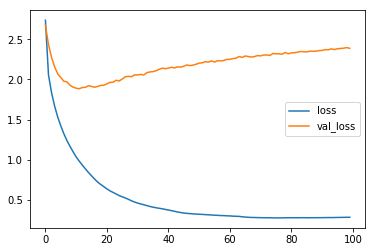

In [32]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

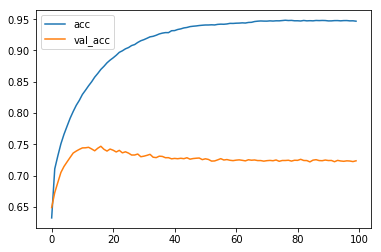

In [33]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [34]:
# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

In [35]:
# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)

In [36]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}


In [37]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']


  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))


  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)

In [38]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[i])
  print('Predicted translation:', translation)
  print('Actual translation:', target_texts[i])

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input sentence: I agreed.
Predicted translation: me sentía toalla.
Actual translation: Acepté. <eos>
Continue? [Y/n]y
-
Input sentence: We sat there.
Predicted translation: nos sentamos allí.
Actual translation: Nos sentamos ahí. <eos>
Continue? [Y/n]y
-
Input sentence: You are good.
Predicted translation: eres bueno.
Actual translation: Estás bien. <eos>
Continue? [Y/n]y
-
Input sentence: We all knew it.
Predicted translation: todos lo sabíamos.
Actual translation: Todos lo sabíamos. <eos>
Continue? [Y/n]y
-
Input sentence: I need a favor.
Predicted translation: necesito una gauchada.
Actual translation: Necesito una gauchada. <eos>
Continue? [Y/n]y
-
Input sentence: I woke you up.
Predicted translation: te he despertado.
Actual translation: Te he despertado. <eos>
Continue? [Y/n]y
-
Input sentence: Are they tall?
Predicted translation: ¿son quería.
Actual translation: ¿Son altos? <eos>
Continue? [Y/n]y
-
Input sentence: What's up, dude?
Predicted translation: ¿qué tengo a yo ¿qué e